In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_curve, precision_recall_curve, auc, confusion_matrix, roc_auc_score, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [8]:
from xgboost import XGBClassifier
md=XGBClassifier()
print(md.get_params())

{'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [2]:
df = pd.read_csv("dataset/disease.csv")
df_test = pd.read_csv("dataset/disease_testing.csv")
df.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis,Unnamed: 133
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN


In [3]:
# droping a useless column named 'Unnamed column'
df.drop('Unnamed: 133',axis =1 , inplace = True)

In [4]:
df.shape

(4920, 133)

In [5]:
# data info: columns with data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Columns: 133 entries, itching to prognosis
dtypes: int64(132), object(1)
memory usage: 5.0+ MB


In [6]:
df['prognosis'].value_counts()

Fungal infection                           120
Hepatitis C                                120
Hepatitis E                                120
Alcoholic hepatitis                        120
Tuberculosis                               120
Common Cold                                120
Pneumonia                                  120
Dimorphic hemmorhoids(piles)               120
Heart attack                               120
Varicose veins                             120
Hypothyroidism                             120
Hyperthyroidism                            120
Hypoglycemia                               120
Osteoarthristis                            120
Arthritis                                  120
(vertigo) Paroymsal  Positional Vertigo    120
Acne                                       120
Urinary tract infection                    120
Psoriasis                                  120
Hepatitis D                                120
Hepatitis B                                120
Allergy      

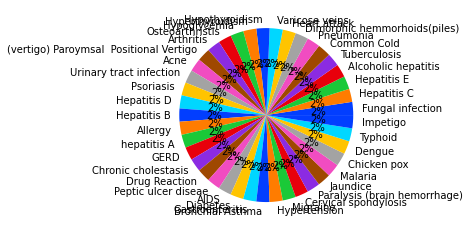

In [7]:
# Number of variables of both stroke and not stroke classes on the dataset
data = df["prognosis"].value_counts()
labels = df["prognosis"].value_counts().index

palette_color = sns.color_palette('bright')
plt.pie(data, labels=labels, colors=palette_color, autopct='%.0f%%');

In [8]:
df.isnull().sum()

itching                 0
skin_rash               0
nodal_skin_eruptions    0
continuous_sneezing     0
shivering               0
                       ..
inflammatory_nails      0
blister                 0
red_sore_around_nose    0
yellow_crust_ooze       0
prognosis               0
Length: 133, dtype: int64

In [9]:
#Encoding
e=LabelEncoder()
df['prognosis']=e.fit_transform(df['prognosis'])
df_test['prognosis']=e.fit_transform(df_test['prognosis'])

In [10]:
#x_train=df.iloc[:, :-2].values
x_train=df.drop("prognosis", axis=1)
x_train.shape

(4920, 132)

In [11]:
y_train=df.iloc[:, 132].values
y_train.shape

(4920,)

In [12]:
x_test=df_test.drop(columns='prognosis',axis=1)
x_test.shape

(42, 132)

In [13]:
y_test=df_test['prognosis']
y_test.shape

(42,)

In [14]:
#Scaling features between -1 and 1
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)

In [15]:
scaler = StandardScaler()
x_test = scaler.fit_transform(x_test)

from sklearn.decomposition import PCA
pca = PCA(0.)
x_train = pca.fit_transform(x_train)
x_train.shape

from sklearn.decomposition import PCA
pca = PCA(0.75)
x_test = pca.fit_transform(x_test)
x_test.shape

Model:  Logistic Regression
Validation Accuracy:  0.9761904761904762
Training Accuracy:  1.0
F1-score: 0.9837398373983739


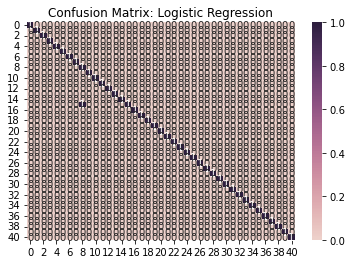

Model:  Decision Tree Classifier
Validation Accuracy:  0.9761904761904762
Training Accuracy:  1.0
F1-score: 0.9837398373983739


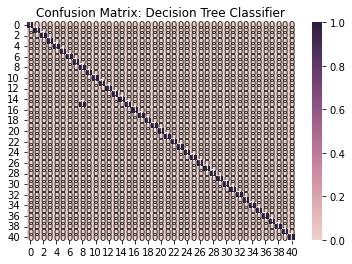

Model:  Random Forest
Validation Accuracy:  0.9761904761904762
Training Accuracy:  1.0
F1-score: 0.9837398373983739


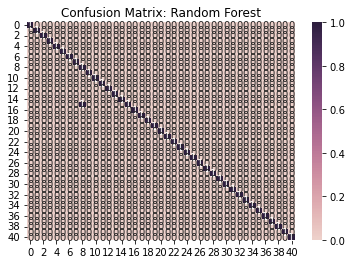

Model:  KNN
Validation Accuracy:  0.9761904761904762
Training Accuracy:  1.0
F1-score: 0.9837398373983739


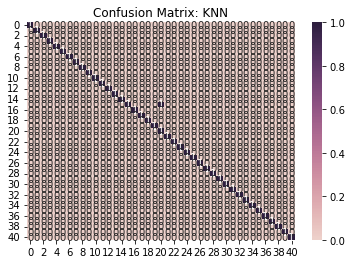

Model:  Support Vector Classifier
Validation Accuracy:  0.9761904761904762
Training Accuracy:  1.0
F1-score: 0.9837398373983739


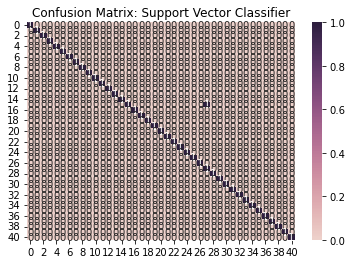

Model:  XG Boost
Validation Accuracy:  0.9761904761904762
Training Accuracy:  1.0
F1-score: 0.9837398373983739


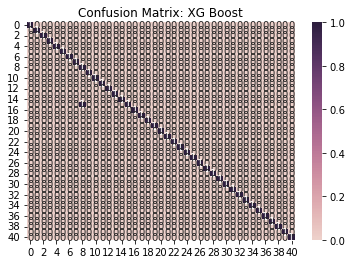

In [16]:
# Models to be used for ML
models = [('Logistic Regression', LogisticRegression()),
          ('Decision Tree Classifier', DecisionTreeClassifier()),
          ('Random Forest', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('Support Vector Classifier', SVC(probability = True)),
          ('XG Boost', XGBClassifier()),]

models_score = []
for name, model in models:
    model = model
    model.fit(x_train, y_train)
    model.predict(x_test)
    models_score.append([name, accuracy_score(y_test, model.predict(x_test))])
    
    print("Model: ",name)
    print('Validation Accuracy: ', accuracy_score(y_test, model.predict(x_test)))
    print('Training Accuracy: ', accuracy_score(y_train, model.predict(x_train)))
    print('F1-score:', f1_score(y_test, model.predict(x_test), average='macro'))

    plt.figure()    
    cf_matrix = confusion_matrix(y_test, model.predict(x_test))
    plt.title('Confusion Matrix: {}'.format(name))
    sns.heatmap(cf_matrix, annot = True, fmt = 'g', cmap = sns.cubehelix_palette(as_cmap=True))
    plt.show()

    

In [17]:
# importing voting classifier
from sklearn.ensemble import VotingClassifier

In [18]:
# initializing all the model objects with default parameters
model_1 = LogisticRegression()
model_2 = DecisionTreeClassifier()
model_3 = RandomForestClassifier()
model_4 = KNeighborsClassifier()
model_5 = SVC(probability = True)
model_6 = XGBClassifier()

In [19]:
# Making the final model using voting classifier
ensemble_model = VotingClassifier(
    estimators=[('lr', model_1), ('dt', model_2), ('rf', model_3), ('knn', model_4), ('svm', model_5), ('xgb', model_6)], voting='hard')

In [20]:
# training all the model on the train dataset
ensemble_model.fit(x_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('dt', DecisionTreeClassifier()),
                             ('rf', RandomForestClassifier()),
                             ('knn', KNeighborsClassifier()),
                             ('svm', SVC(probability=True)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_ca...
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))])

Model:  Ensemble model
Validation Accuracy:  0.9761904761904762
Training Accuracy:  1.0


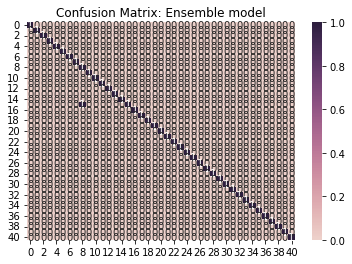

In [21]:
print("Model: ", 'Ensemble model')
print('Validation Accuracy: ', accuracy_score(y_test, ensemble_model.predict(x_test)))
print('Training Accuracy: ', accuracy_score(y_train, ensemble_model.predict(x_train)))
    
plt.figure()
cf_matrix = confusion_matrix(y_test, ensemble_model.predict(x_test))
plt.title('Confusion Matrix: {}'.format('Ensemble model'))
sns.heatmap(cf_matrix, annot = True, fmt = 'g', cmap = sns.cubehelix_palette(as_cmap=True))
plt.show()

In [22]:
dt = DecisionTreeClassifier(criterion = 'entropy',max_depth = 10,max_features = 'sqrt')
dt.fit(x_train, y_train)
dt.predict(x_test)

array([15,  1, 16,  9, 14, 33,  1, 12, 17,  6, 23, 30,  1, 32, 21, 29,  8,
       11, 37, 40, 19, 20, 21, 22,  3, 36, 10, 34, 13, 17, 39, 26, 24, 25,
       31,  5,  0,  2, 38, 35, 27, 35])

In [23]:
print('Validation Accuracy: ', accuracy_score(y_test, dt.predict(x_test)))
print('Training Accuracy: ', accuracy_score(y_train, dt.predict(x_train)))

Validation Accuracy:  0.8809523809523809
Training Accuracy:  0.8536585365853658
